# The Fokas transform pairs

* Course: YSC4103 MCS Capstone
* Date created: 2018/10/07
* Name: Linfan XIAO
* Description: Implement the transform pair (2.15a), (2.15b) on page 10 of "Evolution PDEs and augmented eigenfunctions. Finite interval."

## Importing packages and modules

In [26]:
using NBInclude
using SymPy
using QuadGK
# using HCubature
using ApproxFun
using Roots
using Gadfly
using PyPlot
pygui(true)
include("C:\\Users\\LinFan Xiao\\Academics\\College\\Capstone\\work_in_julia\\construct_adjoint.jl")
include("C:\\Users\\LinFan Xiao\\Academics\\College\\Capstone\\work_in_julia\\construct_adjoint_unit_tests.jl")
include("C:\\Users\\LinFan Xiao\\Academics\\College\\Capstone\\work_in_julia\\approximate_roots_of_exponentialPolynomial.jl")
# @nbinclude("C:\\Users\\LinFan Xiao\\Academics\\College\\Capstone\\work_in_julia\\approximate_roots_of_exponentialPolynomial.ipynb")

approximate_zero (generic function with 1 method)

## Global variables

In [2]:
lambda = symbols("lambda")
x = symbols("x")

sympyAddExpr = 1 + x
sympyMultExpr = 2*x
sympyPowerExpr = x^2
sympyExpExpr = e^x

infty = 50
tol = 1e-15
signif = 3

3

## Helper functions

In [20]:
# Assign string as variable name
function assign(s::AbstractString, v::Any)
    s=Symbol(s)
    @eval (($s) = ($v))
end

# Function addition (f + g)(x) := f(x) + g(x)
function add_func(f::Union{Number, Function}, g::Union{Number, Function})
    function h(x)
        if isa(f, Number)
            if isa(g, Number)
                return f + g
            else
                return f + g(x)
            end
        elseif isa(f, Function)
            if isa(g, Number)
                return f(x) + g
            else
                return f(x) + g(x)
            end
        end
    end
    return h
end

# Function multiplication (f * g)(x) := f(x) * g(x)
function mult_func(f::Union{Number, Function}, g::Union{Number, Function})
    function h(x)
        if isa(f, Number)
            if isa(g, Number)
                return f * g
            else
                return f * g(x)
            end
        elseif isa(f, Function)
            if isa(g, Number)
                return f(x) * g
            else
                return f(x) * g(x)
            end
        end
    end
    return h
end

# function to clean up floating point numbers in (constants and coefficients of) the symbolic expression of an exponential polynomial
# helper function that deals with the case where func(expr) = func(sympyExpExpr)
# although the function body is the same as "others", this case is isolated because negative exponents, e.g., factor_list(e^(-im*x)), give PolynomialError('a polynomial expected, got exp(-I*x)',), while factor_list(cos(x)) runs normally
function clean_up_float_exp(expr::SymPy.Sym)
    term = args(expr)[1]
    termCleaned = clean_up_float_power_add_mult(term)
    result = subs(expr,args(expr)[1],termCleaned)
    return result
end
# helper function that deals with the case where func(expr) = func(sympyPowerExpr)
function clean_up_float_power(expr::SymPy.Sym)
    power = terms[2]
    # powerCleaned = round(power, signif) # floating point powers may cause cleaned numbers to become dirty again for imaginary numbers, e.g., 0.124*I^(1.0) evaluates to 0.12399847344634*I
    powerCleaned = power # assume integer powers, which should be true for exponential polynomials
    result = terms[1]^powerCleaned
    return result
end
# helper function that deals with the case where func(expr) = func(sympyMultExpr)
function clean_up_float_mult(expr::SymPy.Sym)
    terms = args(expr)
    result = 1
    # if the expanded expression contains toplevel multiplication, the individual terms must all be powers
    for term in terms
        # if term is exponential
        if func(term) == func(sympyExpExpr)
            termCleaned = clean_up_float_exp(term)
        # else, further split each product term into indivdual factors
        else
           (constant, factors) = factor_list(term)
            constantCleaned = round(constant, signif)
            termCleaned = constantCleaned
            for (factor, power) in factors
                powerCleaned = power
                factorCleaned = factor^powerCleaned
                termCleaned = termCleaned * factorCleaned
            end 
        end
        result = result * termCleaned
    end
    return result
end
# helper function that deals with the case where func(expr) = func(sympyAddExpr)
function clean_up_float_add(expr::SymPy.Sym)
    terms = args(expr)
    result = 0
    for term in terms
        # if term is exponential
        if func(term) == func(sympyExpExpr)
            termCleaned = clean_up_float_exp(term)
        # else, further split each product term into indivdual factors
        else #if func(term) = func(sympyMultExpr)
            termCleaned = clean_up_float_mult(term)
        end
        result = result + termCleaned
    end
    return result
end
# helper function that deals with the cases where func(expr) = func(sympyPowerExpr), func(sympyAddExpr), func(sympyMultExpr)
function clean_up_float_power_add_mult(expr::SymPy.Sym)
    term = expr
    if func(term) == func(sympyPowerExpr)
        termCleaned = clean_up_float_power(term)
    elseif func(term) == func(sympyAddExpr)
        termCleaned = clean_up_float_add(term)
    else # if func(term) == func(sympyMultExpr)
        termCleaned = clean_up_float_mult(term)
    end
    return termCleaned
end
# helper function that deals with the case where func(expr) != func(sympyPowerExpr), func(sympyAddExpr), func(sympyMultExpr)
function clean_up_float_others(expr::SymPy.Sym)
    # if the expanded expression is neither of the above, it must be a single term, e.g., x or cos(2x+1), which is a function wrapping around an expression; in this case, use the helper function to clean up the expression and feed it back to the function
    term = args(expr)[1]
    termCleaned = clean_up_float_power_add_mult(term)
    result = subs(expr,args(expr)[1],termCleaned)
    return result
end

# main function
function clean_up_float(expr::SymPy.Sym)
    expr = expand(expr)
    if func(expr) == func(sympyPowerExpr)
#         println(expr)
#         println("power!")
        result = clean_up_float_power(expr)
#         println("result = $result")
    elseif func(expr) == func(sympyAddExpr)
#         println(expr)
#         println("addition!")
        result = clean_up_float_add(expr)
#         println("result = $result")
    elseif func(expr) == func(sympyMultExpr)
#         println(expr)
#         println("multiplication!")
        result = clean_up_float_mult(expr)
#         println("result = $result")
    else
        # println(expr)
        # println("single term!")
        result = clean_up_float_others(expr)
        # println("result = $result")
    end
    return result
end

clean_up_float (generic function with 1 method)

In [21]:
expr = 1+5.02*exp(-1.0*im*lambda) # factor_list(expr) gives PolynomialError('a polynomial expected, got exp(-I*x)',)
# expr = 4.33*cos(-1.0*lambda)
func(expr)
args(expr)
# term = exp(-1.0*im*lambda)
# func(term)
# clean_up_float_exp(term)
clean_up_float(expr)

          -1.0*I*lambda
1 + 5.02*e             

## Structs

## Main functions

In [7]:
# Get M+, M- in (2.13a), (2.13b) as functions of lambda (for fixed adjointU) as well as their symbolic expressions
function get_MPlusMinus(adjointU::VectorBoundaryForm; symbolic = false)
    # these are numeric matrices
    bStar, betaStar = adjointU.M, adjointU.N
    n = size(bStar)[1]
    alpha = e^(2pi*im/n)
    if symbolic
        # return MPlus and MMinus as symbolic expressions with (the global variable) lambda as free variable
        MPlusMat = Array{SymPy.Sym}(n,n)
        for k = 1:n
            for j = 1:n
                sumPlus = 0
                for r = 0:(n-1)
                    summandPlus = (-im*alpha^(k-1)*lambda)^r * bStar[j,r+1]
                    summandPlus = expand(summandPlus)
                    sumPlus += summandPlus
                end
                sumPlus = simplify(clean_up_float(sumPlus))
                MPlusMat[k,j] = sumPlus
            end
        end
        MPlusSym = MPlusMat
        MMinusMat = Array{SymPy.Sym}(n,n)
        for k = 1:n
            for j = 1:n
                sumMinus = 0
                for r = 0:(n-1)
                    summandMinus = (-im*alpha^(k-1)*lambda)^r * betaStar[j,r+1]
                    summandMinus = expand(summandMinus)
                    sumMinus += summandMinus
                end
                sumMinus = simplify(clean_up_float(sumMinus))
                MMinusMat[k,j] = sumMinus
            end
        end
        MMinusSym = MMinusMat
        return (MPlusSym, MMinusSym)
    else
        # if not symbolic, return MPlus and MMinus as functions of lambda
        function MPlus(lambda::Number)
            MPlusMat = Array{Number}(n,n)
            for k = 1:n
                for j = 1:n
                    sumPlus = 0
                    for r = 0:(n-1)
                        summandPlus = (-im*alpha^(k-1)*lambda)^r * bStar[j,r+1]
                        sumPlus += summandPlus
                    end
                    MPlusMat[k,j] = sumPlus
                end
            end
            return MPlusMat
        end
        function MMinus(lambda::Number)
            MMinusMat = Array{Number}(n,n)
            for k = 1:n
                for j = 1:n
                    sumMinus = 0
                    for r = 0:(n-1)
                        summandMinus = (-im*alpha^(k-1)*lambda)^r * betaStar[j,r+1]
                        sumMinus += summandMinus
                    end
                    MMinusMat[k,j] = sumMinus
                end
            end
            return MMinusMat
        end
    end
    return (MPlus, MMinus)
end

get_MPlusMinus (generic function with 1 method)

In [8]:
# Get M in (2.14) as a function of lambda (for fixed adjointU) as well as its symbolic expression
function get_M(adjointU::VectorBoundaryForm; symbolic = false)
    bStar, betaStar = adjointU.M, adjointU.N
    n = size(bStar)[1]
    alpha = e^(2pi*im/n)
    if symbolic
        # return M as a symbolic expression with (the global variable) lambda as free variable
        (MPlusSym, MMinusSym) = get_MPlusMinus(adjointU; symbolic = true)
        MLambdaSym = Array{SymPy.Sym}(n,n)
        for k = 1:n
            for j = 1:n
                MLambdaSym[k,j] = simplify(clean_up_float(MPlusSym[k,j] + MMinusSym[k,j] * e^(-im*alpha^(k-1)*lambda)))
            end
        end
        MSym = MLambdaSym
        return MSym
    else
       function M(lambda::Number)
            (MPlus, MMinus) = get_MPlusMinus(adjointU)
            MPlusLambda, MMinusLambda = MPlus(lambda), MMinus(lambda)
            MLambda = Array{Number}(n,n)
            for k = 1:n
                for j = 1:n
                    MLambda[k,j] = MPlusLambda[k,j] + MMinusLambda[k,j] * e^(-im*alpha^(k-1)*lambda)
                end
            end
            return MLambda
        end
        return M 
    end
end

get_M (generic function with 1 method)

In [30]:
# Get delta := det(M) as a function of M(lambda) (for fixed adjointU) as well as its symbolic expression
function get_delta(adjointU::VectorBoundaryForm; symbolic = false)
    if symbolic
        M = get_M(adjointU; symbolic = true)
        deltaSym = simplify(SymPy.det(M))
        return deltaSym
    else
       function delta(lambda::Number)
            M = get_M(adjointU)
            MLambda = convert(Array{Complex}, M(lambda))
            return det(MLambda)
        end
        return delta 
    end
end

get_delta (generic function with 1 method)

## Testing

In [9]:
n = 2
t = symbols("t")
(a,b) = (0,1)
(pFunctions, symPFunctions, pDerivMatrix) = generate_pFunctionsAndSymPFunctions(n; random = true)
symL = SymLinearDifferentialOperator(symPFunctions, (a,b), t)
L = LinearDifferentialOperator(pFunctions, (a,b), symL)
MCandRe = rand(Uniform(1.0,10.0), n, n)
MCandIm = rand(Uniform(1.0,10.0), n, n)
MCand = MCandRe + MCandIm*im
NCandRe = rand(Uniform(1.0,10.0), n, n)
NCandIm = rand(Uniform(1.0,10.0), n, n)
NCand = NCandRe + NCandIm*im
U = VectorBoundaryForm(MCand, NCand)
println(U)
adjointU = construct_validAdjoint(L, U, pDerivMatrix)

VectorBoundaryForm(Complex{Float64}[6.56035+4.86037im 2.08124+6.13352im; 1.68232+8.47663im 2.63176+4.48184im], Complex{Float64}[4.45817+4.78762im 6.57859+6.82851im; 6.61846+6.71789im 1.4143+3.94224im])


VectorBoundaryForm(Complex[-0.0822521+8.20784im 6.31507-2.98417im; -6.31507+2.98417im 1.75278e-16-8.28274e-17im], Complex[44.5223-0.935994im 1.78472-31.1343im; 14.9787+61.293im 17.6321-8.30261im])

In [10]:
println(U.M)
adjointU.M

Complex{Float64}[6.56035+4.86037im 2.08124+6.13352im; 1.68232+8.47663im 2.63176+4.48184im]


2×2 Array{Complex,2}:
 -0.0822521+8.20784im      6.31507-2.98417im    
   -6.31507+2.98417im  1.75278e-16-8.28274e-17im

In [11]:
(MPlus, MMinus) = get_MPlusMinus(adjointU; symbolic = false)
MPlus

MPlus (generic function with 1 method)

In [12]:
(MPlus, MMinus) = get_MPlusMinus(adjointU; symbolic = true)
MPlus

2×2 Array{SymPy.Sym,2}:
 -2.984*lambda - 6.315*I*lambda + 1 + 8.208*I  1 + 2.984*I
  2.984*lambda + 6.315*I*lambda + 1 + 8.208*I  1 + 2.984*I

In [13]:
simplify(SymPy.det(MPlus))

lambda*(31.72 - 30.44*I)

In [14]:
M = get_M(adjointU; symbolic = false)

M (generic function with 1 method)

In [22]:
M = get_M(adjointU; symbolic = true)

2×2 Array{SymPy.Sym,2}:
                            (-31.134*lambda - 1.785*I*lambda + (-2.984*lambda - 6.315*I*lambda + 1 + 8.208*I)*exp(1.0*I*lambda) + 1 - 0.936*I)*exp(-1.0*I*lambda)  …                              (-8.303*lambda - 17.632*I*lambda + (1 + 2.984*I)*exp(1.0*I*lambda) + 1 + 61.293*I)*exp(-1.0*I*lambda)
 31.134*lambda*exp(1.0*I*lambda) + 1.785*I*lambda*exp(1.0*I*lambda) + 2.984*lambda + 6.315*I*lambda + exp(1.0*I*lambda) - 0.936*I*exp(1.0*I*lambda) + 1 + 8.208*I     8.303*lambda*exp(1.0*I*lambda) + 17.632*I*lambda*exp(1.0*I*lambda) + exp(1.0*I*lambda) + 61.293*I*exp(1.0*I*lambda) + 1 + 2.984*I

In [31]:
delta = get_delta(adjointU; symbolic = false)

delta (generic function with 1 method)

In [32]:
delta = get_delta(adjointU; symbolic = true)

/            2  2.0*I*lambda                  2  2.0*I*lambda               2 
\86.57*lambda *e             - 105.05*I*lambda *e             - 86.57*lambda  

                 2                  1.0*I*lambda                    1.0*I*lamb
+ 105.05*I*lambda  + 237.88*lambda*e             - 3830.9*I*lambda*e          

da                  2.0*I*lambda                    2.0*I*lambda              
   + 221.85*lambda*e             - 198.12*I*lambda*e             + 221.85*lamb

                               2.0*I*lambda             2.0*I*lambda          
da - 198.12*I*lambda - 505.89*e             + 67.453*I*e             + 505.89 

          \  -1.0*I*lambda
- 67.453*I/*e             

In [27]:
separatedDelta = separate_real_imaginary(delta)

term = 237.88
termSeparated = 237.88
term = x
termSeparated = x
term = 3830.9
termSeparated = 3830.9
term = y
termSeparated = y
term = 237.88
termSeparated = 237.88
term = I
termSeparated = I
term = y
termSeparated = y
term = 505.89
termSeparated = 505.89
term = exp(1.0*y)
termSeparated = exp(1.0*y)
term = exp(-1.0*I*x)
termSeparated = -I*sin(1.0*x) + cos(1.0*x)
term = -505.89
termSeparated = -505.89
term = exp(-1.0*y)
termSeparated = exp(-1.0*y)
term = exp(1.0*I*x)
termSeparated = I*sin(1.0*x) + cos(1.0*x)
term = -3830.9
termSeparated = -3830.9
term = I
termSeparated = I
term = x
termSeparated = x
term = 198.12
termSeparated = 198.12
term = y
termSeparated = y
term = exp(1.0*y)
termSeparated = exp(1.0*y)
term = exp(-1.0*I*x)
termSeparated = -I*sin(1.0*x) + cos(1.0*x)
term = 221.85
termSeparated = 221.85
term = x
termSeparated = x
term = exp(-1.0*y)
termSeparated = exp(-1.0*y)
term = exp(1.0*I*x)
termSeparated = I*sin(1.0*x) + cos(1.0*x)
term = 67.453
termSeparated = 67.453
term = I
te

        2  1.0*y                     2  1.0*y                      2  -1.0*y  
105.05*x *e     *sin(1.0*x) - 86.57*x *e     *cos(1.0*x) + 105.05*x *e      *s

                   2  -1.0*y                          1.0*y                   
in(1.0*x) + 86.57*x *e      *cos(1.0*x) - 173.14*x*y*e     *sin(1.0*x) - 210.0

       1.0*y                          -1.0*y                          -1.0*y  
9*x*y*e     *cos(1.0*x) - 173.14*x*y*e      *sin(1.0*x) + 210.09*x*y*e      *c

                      1.0*y                        1.0*y                      
os(1.0*x) - 198.12*x*e     *sin(1.0*x) + 221.85*x*e     *cos(1.0*x) + 237.88*x

             -1.0*y                        -1.0*y                      2  1.0*
 + 198.12*x*e      *sin(1.0*x) + 221.85*x*e      *cos(1.0*x) - 105.05*y *e    

y                     2  1.0*y                      2  -1.0*y                 
 *sin(1.0*x) + 86.57*y *e     *cos(1.0*x) - 105.05*y *e      *sin(1.0*x) - 86.

    2  -1.0*y                        1.0*y    

In [29]:
plot_level_curves(separatedDelta)

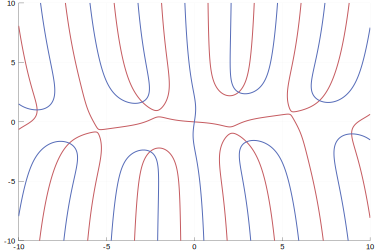

In [28]:
plot_level_curves(separatedDelta; xRange = (-10,10), yRange = (-10,10))